In [71]:

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the RDS file
readRDS = robjects.r['readRDS']
pce_data = readRDS('/Users/sarahurbut/Library/Cloudstorage/Dropbox/pce_df_prevent.rds')
pce_df = pandas2ri.rpy2py(pce_data)  # Convert to pandas DataFrame


In [72]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from clust_huge_amp import *
from fig5utils import *
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


DO the analysis with data stopped at enrollment

In [73]:

# Load and initialize model:
Y, E, G, essentials = load_model_essentials(base_path='/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/')
# When initializing the model:
original_G = G # Store the original G - proper tensor copy

# Now in your batch run, load and verify:
initial_psi = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/initial_psi_400k.pt')
initial_clusters = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/initial_clusters_400k.pt')
# Subset the data
Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, start_index=0, end_index=10000)

Loading components...


/Users/sarahurbut/aladynoulli2/pyScripts/fig5utils.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/Users/sarahurbut/aladynoul

Loaded all components successfully!


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_89680/159635465.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/Li

In [74]:
# Example calls:
from fig5utils import *
checkpoint_path = '/Users/sarahurbut/Library/Cloudstorage/Dropbox/enrollment_model_W0.0001_jointphi_sexspecific_0_10000.pt'
#checkpoint_path = '/Users/sarahurbut/Library/Cloudstorage/Dropbox/enrollment_model_W0.0001_fulldata_sexspecific.pt'
checkpoint = torch.load(checkpoint_path)


Y_100k, E_100k, G_100k, indices = subset_data(Y,E,G, start_index=0, end_index=10000)
G_100k=checkpoint['G']
torch.manual_seed(42)
np.random.seed(42)
# Load references (signatures only, no healthy)
refs = torch.load('/Users/sarahurbut/Library/Cloudstorage/Dropbox/data_for_running/reference_trajectories.pt')
signature_refs = refs['signature_refs']
# When initializing the model:

torch.manual_seed(7)
np.random.seed(4)
# Create model without healthy reference
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0], 
    D=Y_100k.shape[1], 
    T=Y_100k.shape[2], 
    K=20,
    P=G_100k.shape[1],
    init_sd_scaler=1e-1,
    G=G_100k, 
    Y=Y_100k,
    genetic_scale=1,
    W=0.0001,
    R=0,
    prevalence_t=essentials['prevalence_t'],
    signature_references=signature_refs,  # Only pass signature refs
    healthy_reference=True,  # Explicitly set to None
    disease_names=essentials['disease_names']
)

torch.manual_seed(0)
np.random.seed(0)
# Initialize with psi and clusters
model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters
model.load_state_dict(checkpoint['model_state_dict'])
model.G.shape

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_89680/1409335849.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
/var


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 14
Base value (first 5): tensor([-13.8155, -13.8155, -13.1095, -12.4036, -12.4036])
Base value centered (first 5): tensor([-0.3723, -0.3723,  0.3336,  1.0396,  1.0396])
Base value centered mean: 6.57081614008348e-07
Gamma init for k=0 (first 5): tensor([ 0.0008,  0.0071,  0.0117,  0.0152, -0.0106])

Calculating gamma for k=1:
Number of diseases in cluster: 7
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered

torch.Size([10000, 37])

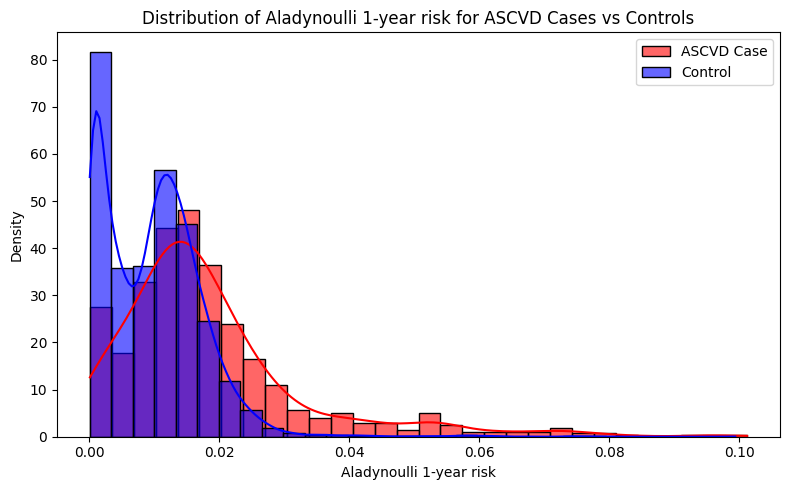

In [76]:

# Get predictions (pi) from the model
with torch.no_grad():
    pi, _, _ = model.forward()  # pi shape: (N, D, T)
test_start=0
test_end=10000

Y_test = Y[test_start:test_end]
FH_test = fh_processed.iloc[test_start:test_end].reset_index(drop=True)
# For each subject, get their enrollment age (from your covariate DataFrame)
# Suppose FH_train is your DataFrame for the training set (reset index to match order)
aladynoulli_1yr_risk_test = []
for i, row in FH_test.iterrows():
    enroll_time = int(row['age'] - 30)
    # Choose the disease indices you want (e.g., ASCVD indices)
    # For a single disease: d_idx = ...
    # For a group: d_indices = [...]
    # Example for ASCVD:
    d_indices = [111, 112, 113, 114, 115, 116]  # adjust as needed
    if enroll_time < 0 or enroll_time >= pi.shape[2]:
        aladynoulli_1yr_risk_train.append(np.nan)
        continue
    # 1-year risk for ASCVD group at enrollment
    pi_diseases = pi[i, d_indices, enroll_time]
    yearly_risk = 1 - torch.prod(1 - pi_diseases)
    aladynoulli_1yr_risk_test.append(yearly_risk.item())

import numpy as np
import torch
ascvd_indices=[111,112,113,114,115,116]
cases = []
controls = []
for i in range(len(FH_test)):
    age = FH_test.iloc[i]['age']
    t_enroll = int(age - 30)
    if t_enroll < 0 or t_enroll >= Y_test.shape[2]:
        continue
    end_time = min(t_enroll + 10, Y_test.shape[2])
    had_event = 0
    for d_idx in ascvd_indices:
        if torch.any(Y_test[i, d_idx, t_enroll:end_time] > 0):
            had_event = 1
            break
    if had_event:
        cases.append(aladynoulli_1yr_risk_test[i])
    else:
        controls.append(aladynoulli_1yr_risk_test[i])
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(cases, color='red', label='ASCVD Case', kde=True, stat='density', bins=30, alpha=0.6)
sns.histplot(controls, color='blue', label='Control', kde=True, stat='density', bins=30, alpha=0.6)
plt.xlabel('Aladynoulli 1-year risk')
plt.ylabel('Density')
plt.title('Distribution of Aladynoulli 1-year risk for ASCVD Cases vs Controls')
plt.legend()
plt.tight_layout()
plt.show()

In [77]:
# Calculate bootstrap results
from fig5utils import *
# static model saving 
aladynoulli_results_boot = evaluate_major_diseases_wsex_with_bootstrap(model, Y_100k, E_100k, model.disease_names, pce_df, n_bootstraps=20, follow_up_duration_years=10)
# 6. Evaluate Baseline Models on TEST data <-- UNCOMMENT THIS



Evaluating ASCVD (10-Year Outcome, 1-Year Score)...
AUC: 0.712 (0.693-0.724) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 831 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

   Sex-stratified analysis:
   Female: AUC = 0.668, Events = 273/5409
   Male: AUC = 0.701, Events = 558/4591

   ASCVD risk in patients with pre-existing conditions:
   RA: AUC = 0.681, Events = 8/37
   Breast_Cancer: AUC = 0.630, Events = 13/170

Evaluating Diabetes (10-Year Outcome, 1-Year Score)...
AUC: 0.622 (0.606-0.636) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 581 (5.8%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

   Sex-stratified analysis:
   Female: AUC = 0.611, Events = 264/5409
   Male: AUC = 0.624, Events = 317/4591

Evaluating Atrial_Fib (10-Year Outcome, 1-Year Score)...
AUC: 0.684 (0.657-0.707) (calculated on 9864 individuals)
Events (10-Year in Eval Cohort): 376 (3.8%) (from 10000 individuals)
Excluded 13


ROC AUC Comparison (10-year prediction from enrollment):
Our model: 0.712
PREVENT: 0.653


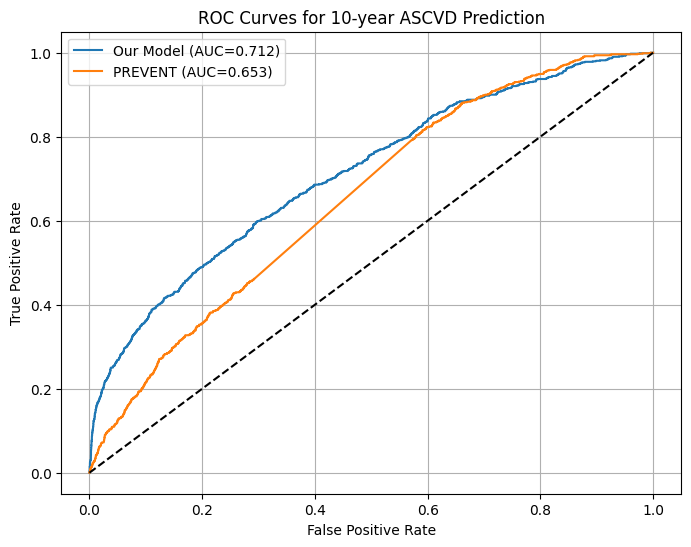

In [78]:
compare_with_prevent(model, pce_df, [111, 112, 113, 114, 115, 116])

In [80]:
from fig5utils import *
# 1. Define Train Indices 
train_indices = np.arange(20000, 30000) # Example

# 2. Define Test Data (using Y_100k and FH_processed subset aligned to it)
Y_test_eval = Y_100k 
fh_processed=pd.read_csv('/Users/sarahurbut/Library/Cloudstorage/Dropbox/baselinagefamh.csv')
FH_test_eval = fh_processed.iloc[0:10000] # Make sure FH_test_eval aligns with Y_100k


# 3. Set Follow-up duration
follow_up = 10

fitted_models = fit_cox_baseline_models(
    Y_full=Y,  # Your full Y tensor
    FH_processed=fh_processed,  # Your processed family history DataFrame
    train_indices=np.arange(20000, 30000),  # Training indices
    disease_mapping=disease_mapping,  # Dictionary mapping disease groups to FH columns
    major_diseases=major_diseases,  # Dictionary of disease groups and their names
    disease_names=model.disease_names,  # List of all disease names
    follow_up_duration_years=10  # Optional: follow-up duration in years
)


Fitting Cox models using training indices [20000:30000]...
 - Fitting ASCVD...
   age_enroll  age  event  sex     fh
0        54.0   63      0  0.0   True
1        60.0   69      0  1.0  False
2        51.0   60      0  0.0  False
3        63.0   72      0  0.0   True
4        57.0   66      0  0.0  False
(10000, 5)
      age_enroll  age  event  sex     fh
151         68.0   68      1  1.0   True
442         65.0   65      1  1.0   True
452         55.0   55      1  1.0  False
663         62.0   62      1  1.0   True
1517        65.0   65      1  1.0   True
1580        62.0   62      1  1.0  False
1730        64.0   64      1  1.0  False
1799        58.0   58      1  1.0  False
1919        62.0   62      1  1.0  False
1968        51.0   51      1  1.0  False
2592        65.0   65      1  1.0  False
2744        69.0   69      1  0.0  False
2997        61.0   61      1  1.0  False
3131        63.0   63      1  1.0  False
4049        67.0   67      1  1.0   True
4269        60.0   60     

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_89680/2344104618.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)[

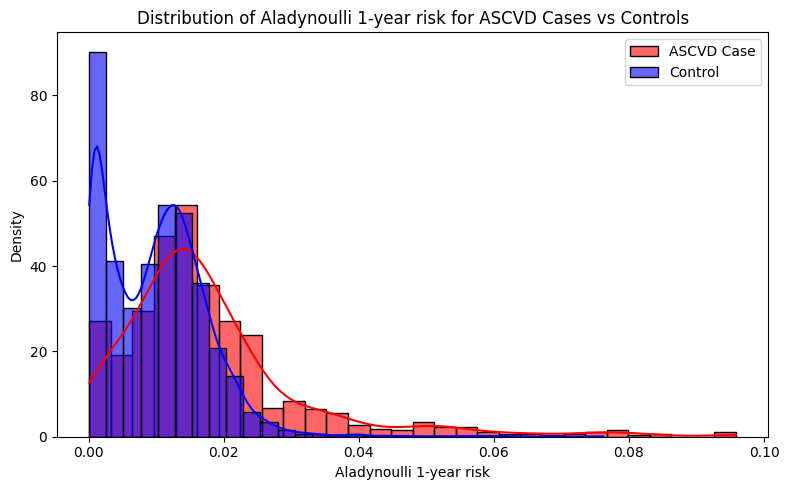

In [ ]:

model_path='/Users/sarahurbut/Library/CloudStorage/Dropbox/resultsenrollAWS/results/output_0_10000/model.pt'

model.load_state_dict(torch.load(model_path)['model_state_dict'])

# Get predictions (pi) from the model
with torch.no_grad():
    pi, _, _ = model.forward()  # pi shape: (N, D, T)

test_end

Y_test = Y[test_start:test_end]
FH_test = fh_processed.iloc[test_start:test_end].reset_index(drop=True)
# For each subject, get their enrollment age (from your covariate DataFrame)
# Suppose FH_train is your DataFrame for the training set (reset index to match order)
aladynoulli_1yr_risk_test = []
for i, row in FH_test.iterrows():
    enroll_time = int(row['age'] - 30)
    # Choose the disease indices you want (e.g., ASCVD indices)
    # For a single disease: d_idx = ...
    # For a group: d_indices = [...]
    # Example for ASCVD:
    d_indices = [111, 112, 113, 114, 115, 116]  # adjust as needed
    if enroll_time < 0 or enroll_time >= pi.shape[2]:
        aladynoulli_1yr_risk_train.append(np.nan)
        continue
    # 1-year risk for ASCVD group at enrollment
    pi_diseases = pi[i, d_indices, enroll_time]
    yearly_risk = 1 - torch.prod(1 - pi_diseases)
    aladynoulli_1yr_risk_test.append(yearly_risk.item())

import numpy as np
import torch
ascvd_indices=[111,112,113,114,115,116]
cases = []
controls = []
for i in range(len(FH_test)):
    age = FH_test.iloc[i]['age']
    t_enroll = int(age - 30)
    if t_enroll < 0 or t_enroll >= Y_test.shape[2]:
        continue
    end_time = min(t_enroll + 10, Y_test.shape[2])
    had_event = 0
    for d_idx in ascvd_indices:
        if torch.any(Y_test[i, d_idx, t_enroll:end_time] > 0):
            had_event = 1
            break
    if had_event:
        cases.append(aladynoulli_1yr_risk_test[i])
    else:
        controls.append(aladynoulli_1yr_risk_test[i])
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(cases, color='red', label='ASCVD Case', kde=True, stat='density', bins=30, alpha=0.6)
sns.histplot(controls, color='blue', label='Control', kde=True, stat='density', bins=30, alpha=0.6)
plt.xlabel('Aladynoulli 1-year risk')
plt.ylabel('Density')
plt.title('Distribution of Aladynoulli 1-year risk for ASCVD Cases vs Controls')
plt.legend()
plt.tight_layout()
plt.show()

In [88]:
Y[20442,[111,112,113,114,115,116],35]


tensor([0., 1., 0., 0., 0., 0.])

In [89]:

fh_processed.iloc[20442]


identifier           1252691.0
age                       65.0
sex                        1.0
heart_disease              1.0
stroke                     0.0
lung_cancer                0.0
bowel_cancer               0.0
breast_cancer              0.0
copd                       0.0
hypertension               0.0
diabetes                   0.0
alzheimer                  0.0
parkinsons                 0.0
depression                 0.0
prostate_cancer            0.0
hip_fracture               0.0
heart_disease.1            1.0
stroke.1                   0.0
lung_cancer.1              0.0
bowel_cancer.1             0.0
breast_cancer.1            0.0
copd.1                     0.0
hypertension.1             0.0
diabetes.1                 0.0
alzheimer.1                0.0
parkinsons.1               0.0
depression.1               0.0
prostate_cancer.1          0.0
hip_fracture.1             0.0
Name: 20442, dtype: float64

In [9]:
cox_results_auc = evaluate_cox_baseline_models_auc(
    fitted_models=fitted_models,
    Y_test=Y_100k,
    FH_test=fh_processed.iloc[0:10000],
    disease_mapping=disease_mapping,
    major_diseases=major_diseases,
    disease_names=model.disease_names,
    follow_up_duration_years=10
)


Evaluating Cox models on test data (10-year AUC)...
 - Evaluating ASCVD...
   10-year AUC: 0.684 (0.662-0.706) | Events: 530/10000
 - Evaluating Diabetes...
   10-year AUC: 0.645 (0.620-0.665) | Events: 581/10000
 - Evaluating Atrial_Fib...
   10-year AUC: 0.712 (0.687-0.735) | Events: 376/10000
 - Evaluating CKD...
   10-year AUC: 0.699 (0.656-0.746) | Events: 104/10000
 - Evaluating All_Cancers...
   10-year AUC: 0.713 (0.685-0.737) | Events: 319/10000
 - Evaluating Stroke...
   10-year AUC: 0.647 (0.540-0.713) | Events: 49/10000
 - Evaluating Heart_Failure...
   10-year AUC: 0.769 (0.716-0.809) | Events: 84/10000
 - Evaluating Pneumonia...
   10-year AUC: 0.687 (0.667-0.711) | Events: 335/10000
 - Evaluating COPD...
   10-year AUC: 0.652 (0.624-0.684) | Events: 272/10000
 - Evaluating Osteoporosis...
   10-year AUC: 0.736 (0.697-0.769) | Events: 219/10000
 - Evaluating Anemia...
   10-year AUC: 0.568 (0.524-0.599) | Events: 272/10000
 - Evaluating Colorectal_Cancer...
   10-year AU

In [10]:
import pandas as pd

# Create DataFrame from both results
df_compare = []
for disease in aladynoulli_results_boot.keys():
    aladyn = aladynoulli_results_boot[disease]
    cox = cox_results_auc.get(disease, {})
    
    row = {
        'Disease': disease,
        'Aladynoulli_AUC': f"{aladyn['auc']:.3f} ({aladyn['ci_lower']:.3f}-{aladyn['ci_upper']:.3f})",
        'Cox_AUC': f"{cox.get('auc', np.nan):.3f} ({cox.get('ci', (np.nan, np.nan))[0]:.3f}-{cox.get('ci', (np.nan, np.nan))[1]:.3f})" if cox.get('auc') is not None else "N/A",
        'Events': aladyn['n_events'],
        'Rate': f"{aladyn['event_rate']:.1f}%"
    }
    df_compare.append(row)

df_compare = pd.DataFrame(df_compare)

# Sort by number of events descending
df_compare = df_compare.sort_values('Events', ascending=False)

# Save to CSV for R
df_compare.to_csv('model_comparison_results_bootstatic_auc.csv', index=False)

# Display nicely formatted table in Python
print("\nModel Comparison Results:")
print("-" * 100)
print(df_compare.to_string(index=False))


Model Comparison Results:
----------------------------------------------------------------------------------------------------
             Disease     Aladynoulli_AUC             Cox_AUC  Events Rate
               ASCVD 0.712 (0.693-0.724) 0.684 (0.662-0.706)     831 8.3%
              Asthma 0.511 (0.485-0.532) 0.499 (0.470-0.518)     606 6.1%
            Diabetes 0.622 (0.606-0.636) 0.645 (0.620-0.665)     581 5.8%
              Anemia 0.593 (0.577-0.613) 0.568 (0.524-0.599)     523 5.2%
         All_Cancers 0.680 (0.664-0.699) 0.713 (0.685-0.737)     480 4.8%
   Thyroid_Disorders 0.579 (0.561-0.601) 0.634 (0.613-0.653)     479 4.8%
          Depression 0.470 (0.449-0.498) 0.474 (0.450-0.502)     405 4.0%
                COPD 0.646 (0.616-0.666) 0.652 (0.624-0.684)     394 3.9%
          Atrial_Fib 0.684 (0.657-0.707) 0.712 (0.687-0.735)     376 3.8%
           Pneumonia 0.683 (0.663-0.708) 0.687 (0.667-0.711)     335 3.4%
    Secondary_Cancer 0.607 (0.585-0.636) 0.630 (0.584-0.67

In [11]:
from fig5utils import *
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message="DataFrame Index is not unique")
cox_results_c=evaluate_cox_baseline_models(
    fitted_models=fitted_models,
    Y_test=Y_100k,
    FH_test=fh_processed.iloc[0:10000],
    disease_mapping=disease_mapping,
    major_diseases=major_diseases,
    disease_names=model.disease_names,
    follow_up_duration_years=10
)


Evaluating Cox models on test data...
 - Evaluating ASCVD...
   Overall C-index: 0.650 (0.628-0.668)
   Events: 708/20000

   Sex-stratified analysis:
   Female: C-index = 0.519, Events = 195/10818
   Male: C-index = 0.541, Events = 513/9182

   ASCVD risk in patients with pre-existing conditions:
   RA: C-index = 0.824, Events = 3/74
   Breast_Cancer: C-index = 0.411, Events = 6/340
 - Evaluating Diabetes...
   Overall C-index: 0.606 (0.582-0.633)
   Events: 598/20000

   Sex-stratified analysis:
   Female: C-index = 0.591, Events = 271/10818
   Male: C-index = 0.562, Events = 327/9182
 - Evaluating Atrial_Fib...
   Overall C-index: 0.584 (0.561-0.609)
   Events: 376/9864
   Excluded 136 prevalent cases for Atrial_Fib.

   Sex-stratified analysis:
   Female: C-index = 0.500, Events = 139/5372
   Male: C-index = 0.500, Events = 237/4492
 - Evaluating CKD...
   Overall C-index: 0.555 (0.502-0.603)
   Events: 104/9980
   Excluded 20 prevalent cases for CKD.

   Sex-stratified analysis:


In [12]:
import pandas as pd

# Create DataFrame from both results
df_compare = []
for disease in aladynoulli_results_boot.keys():
    aladyn = aladynoulli_results_boot[disease]
    cox = cox_results_c.get(disease, {})
    
    row = {
        'Disease': disease,
        'Aladynoulli_AUC': f"{aladyn['auc']:.3f} ({aladyn['ci_lower']:.3f}-{aladyn['ci_upper']:.3f})",
        'Cox_Concordance': f"{cox.get('c_index', np.nan):.3f} ({cox.get('ci', (np.nan, np.nan))[0]:.3f}-{cox.get('ci', (np.nan, np.nan))[1]:.3f})" if cox.get('c_index') is not None else "N/A",
        'Events': aladyn['n_events'],
        'Rate': f"{aladyn['event_rate']:.1f}%"
    }
    df_compare.append(row)

df_compare = pd.DataFrame(df_compare)

# Sort by number of events descending
df_compare = df_compare.sort_values('Events', ascending=False)

# Save to CSV for R
df_compare.to_csv('model_comparison_results_cindex.csv', index=False)

# Display nicely formatted table in Python
print("\nModel Comparison Results:")
print("-" * 100)
print(df_compare.to_string(index=False))


Model Comparison Results:
----------------------------------------------------------------------------------------------------
             Disease     Aladynoulli_AUC     Cox_Concordance  Events Rate
               ASCVD 0.712 (0.693-0.724) 0.650 (0.628-0.668)     831 8.3%
              Asthma 0.511 (0.485-0.532) 0.520 (0.499-0.538)     606 6.1%
            Diabetes 0.622 (0.606-0.636) 0.606 (0.582-0.633)     581 5.8%
              Anemia 0.593 (0.577-0.613) 0.549 (0.519-0.574)     523 5.2%
         All_Cancers 0.680 (0.664-0.699) 0.615 (0.586-0.640)     480 4.8%
   Thyroid_Disorders 0.579 (0.561-0.601) 0.649 (0.622-0.671)     479 4.8%
          Depression 0.470 (0.449-0.498) 0.559 (0.538-0.580)     405 4.0%
                COPD 0.646 (0.616-0.666) 0.535 (0.506-0.566)     394 3.9%
          Atrial_Fib 0.684 (0.657-0.707) 0.584 (0.561-0.609)     376 3.8%
           Pneumonia 0.683 (0.663-0.708) 0.561 (0.533-0.592)     335 3.4%
    Secondary_Cancer 0.607 (0.585-0.636) 0.474 (0.436-0.51

In [14]:
# Get indices for RA and Breast Cancer
from fig5utils import *

disease_names=model.disease_names
ra_patients = get_preexisting_patient_indices(Y_100k, pce_df, disease_names, 'Rheumatoid_Arthritis')
bc_patients = get_preexisting_patient_indices(Y_100k, pce_df, disease_names, 'Breast_Cancer')

# PCE/PREVENT AUC for the same patients
auc_pce_ra, auc_prevent_ra = pce_prevent_auc_for_preexisting(Y_100k, pce_df, ra_patients, disease_names)
auc_pce_bc, auc_prevent_bc = pce_prevent_auc_for_preexisting(Y_100k, pce_df, bc_patients, disease_names)

PCE AUC: 0.690, PREVENT AUC: 0.659
PCE AUC: 0.528, PREVENT AUC: 0.544


Dynamic results

In [15]:
# use ernollment tested model to make projections forward
checkpoint_path = '/Users/sarahurbut/Library/Cloudstorage/Dropbox/enrollment_model_W0.0001_fulldata_sexspecific.pt'
c=torch.load(checkpoint_path)
model.load_state_dict(c['model_state_dict'])
dynamic_bootstrap_results = evaluate_major_diseases_wsex_with_bootstrap_dynamic(model, Y_100k, E_100k, model.disease_names, pce_df, n_bootstraps=20, follow_up_duration_years=10)


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_89680/1686319557.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  c=torch.load(checkpoint_path)



Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.875 (0.864-0.887) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 831 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.741 (0.726-0.764) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 581 (5.8%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.775 (0.757-0.798) (calculated on 9864 individuals)
Events (10-Year in Eval Cohort): 376 (3.8%) (from 9864 individuals)
Excluded 136 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.751 (0.724-0.777) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 207 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.765 (0.741-0.787) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 480 (4

In [16]:
# For RA
from fig5utils import *
disease_names = model.disease_names
ra_results = dynamic_aladynoulli_auc_for_preexisting(model, Y_100k, E_100k, disease_names, pce_df, 'Rheumatoid_Arthritis')
# For Breast Cancer
bc_results = dynamic_aladynoulli_auc_for_preexisting(model, Y_100k, E_100k, disease_names, pce_df, 'Breast_Cancer')



Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.841 (0.589-1.000) (calculated on 37 individuals)
Events (10-Year in Eval Cohort): 8 (21.6%) (from 37 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.602 (0.352-0.969) (calculated on 37 individuals)
Events (10-Year in Eval Cohort): 6 (16.2%) (from 37 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.845 (0.663-0.969) (calculated on 36 individuals)
Events (10-Year in Eval Cohort): 5 (13.9%) (from 36 individuals)
Excluded 1 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.833 (0.642-1.000) (calculated on 37 individuals)
Events (10-Year in Eval Cohort): 3 (8.1%) (from 37 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.278 (0.158-0.435) (calculated on 37 individuals)
Events (10-Year in Eval Cohort): 1 (2.7%) (from 37 individuals)
Exclude

In [17]:
import pandas as pd

# Create DataFrame from both results
df_compare = []
for disease in aladynoulli_results_boot.keys():
    aladyn = dynamic_bootstrap_results[disease]
    cox = cox_results_auc.get(disease, {})
    
    row = {
        'Disease': disease,
        'Aladynoulli_AUC': f"{aladyn['auc']:.3f} ({aladyn['ci_lower']:.3f}-{aladyn['ci_upper']:.3f})",
        'Cox_AUC': f"{cox.get('auc', np.nan):.3f} ({cox.get('ci', (np.nan, np.nan))[0]:.3f}-{cox.get('ci', (np.nan, np.nan))[1]:.3f})" if cox.get('auc') is not None else "N/A",
        'Events': aladyn['n_events'],
        'Rate': f"{aladyn['event_rate']:.1f}%"
    }
    df_compare.append(row)

df_compare = pd.DataFrame(df_compare)

# Sort by number of events descending
df_compare = df_compare.sort_values('Events', ascending=False)

# Save to CSV for R
df_compare.to_csv('model_comparison_results_dynamic.csv', index=False)

# Display nicely formatted table in Python
print("\nModel Comparison Results:")
print("-" * 100)
print(df_compare.to_string(index=False))


Model Comparison Results:
----------------------------------------------------------------------------------------------------
             Disease     Aladynoulli_AUC             Cox_AUC  Events Rate
               ASCVD 0.875 (0.864-0.887) 0.684 (0.662-0.706)     831 8.3%
              Asthma 0.691 (0.672-0.704) 0.499 (0.470-0.518)     606 6.3%
            Diabetes 0.741 (0.726-0.764) 0.645 (0.620-0.665)     581 5.8%
              Anemia 0.719 (0.699-0.736) 0.568 (0.524-0.599)     523 5.2%
         All_Cancers 0.765 (0.741-0.787) 0.713 (0.685-0.737)     480 4.8%
   Thyroid_Disorders 0.709 (0.685-0.729) 0.634 (0.613-0.653)     479 4.8%
          Depression 0.673 (0.639-0.703) 0.474 (0.450-0.502)     405 4.1%
                COPD 0.760 (0.734-0.780) 0.652 (0.624-0.684)     394 3.9%
          Atrial_Fib 0.775 (0.757-0.798) 0.712 (0.687-0.735)     376 3.8%
           Pneumonia 0.784 (0.761-0.807) 0.687 (0.667-0.711)     335 3.4%
    Secondary_Cancer 0.715 (0.665-0.749) 0.630 (0.584-0.67

# compare cox with noulli added 

In [68]:

# Load and initialize model:
Y, E, G, essentials = load_model_essentials(base_path='/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/')
# When initializing the model:
original_G = G # Store the original G - proper tensor copy

# Now in your batch run, load and verify:
initial_psi = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/initial_psi_400k.pt')
initial_clusters = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/initial_clusters_400k.pt')
# Subset the data
Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, start_index=0, end_index=10000)

torch.manual_seed(42)
np.random.seed(42)
# Load references (signatures only, no healthy)
refs = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/reference_trajectories.pt')
signature_refs = refs['signature_refs']
# When initializing the model:

torch.manual_seed(7)
np.random.seed(4)
# Create model without healthy reference
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0], 
    D=Y_100k.shape[1], 
    T=Y_100k.shape[2], 
    K=20,
    P=G_100k.shape[1],
    init_sd_scaler=1e-1,
    G=G_100k, 
    Y=Y_100k,
    genetic_scale=1,
    W=0.0001,
    R=0,
    prevalence_t=essentials['prevalence_t'],
    signature_references=signature_refs,  # Only pass signature refs
    healthy_reference=True,  # Explicitly set to None
    disease_names=essentials['disease_names']
)

torch.manual_seed(0)
np.random.seed(0)
# Initialize with psi and clusters
model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters

train_indices=np.arange(20000, 30000)
FH_train = fh_processed.iloc[train_indices].reset_index(drop=True)
FH_train.shape
FH_train.tail()
# Load the model
model_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/resultsenrollAWS/results/output_20000_30000/model.pt'
model.load_state_dict(torch.load(model_path)['model_state_dict'])

# Get predictions (pi) from the model
with torch.no_grad():
    pi, _, _ = model.forward()  # pi shape: (N, D, T)

# For each subject, get their enrollment age (from your covariate DataFrame)
# Suppose FH_train is your DataFrame for the training set (reset index to match order)
aladynoulli_1yr_risk_train = []
for i, row in FH_train.iterrows():
    enroll_time = int(row['age'] - 30)
    # Choose the disease indices you want (e.g., ASCVD indices)
    # For a single disease: d_idx = ...
    # For a group: d_indices = [...]
    # Example for ASCVD:
    d_indices = [111, 112, 113, 114, 115, 116]  # adjust as needed
    if enroll_time < 0 or enroll_time >= pi.shape[2]:
        aladynoulli_1yr_risk_train.append(np.nan)
        continue
    # 1-year risk for ASCVD group at enrollment
    pi_diseases = pi[i, d_indices, enroll_time]
    yearly_risk = 1 - torch.prod(1 - pi_diseases)
    aladynoulli_1yr_risk_train.append(yearly_risk.item())

aladynoulli_1yr_risk_train = np.array(aladynoulli_1yr_risk_train)

batch_start = 20000
batch_end = 30000

# Slice your data for the batch
Y_batch = Y[batch_start:batch_end]
FH_batch = fh_processed.iloc[batch_start:batch_end].reset_index(drop=True)
aladynoulli_1yr_risk_batch = aladynoulli_1yr_risk_train  # Should already be length 10,000

# Indices are now 0-based for this batch
relative_train_indices = np.arange(0, batch_end - batch_start)
train_indices=np.arange(20000, 30000)

# Fit the Cox model with Aladynoulli 1-year risk as covariate
fitted_models = fit_cox_baseline_models_with_aladynoulli(
    Y_batch,
    FH_batch,
    aladynoulli_1yr_risk_batch,
    train_indices=relative_train_indices,
    disease_mapping=disease_mapping,
    major_diseases=major_diseases,
    disease_names=disease_names,
    follow_up_duration_years=10
)

Loading components...


/Users/sarahurbut/aladynoulli2/pyScripts/fig5utils.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/Users/sarahurbut/aladynoul

Loaded all components successfully!

Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_89680/1855198114.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/L


Calculating gamma for k=0:
Number of diseases in cluster: 14
Base value (first 5): tensor([-13.8155, -13.8155, -13.1095, -12.4036, -12.4036])
Base value centered (first 5): tensor([-0.3723, -0.3723,  0.3336,  1.0396,  1.0396])
Base value centered mean: 6.57081614008348e-07
Gamma init for k=0 (first 5): tensor([ 0.0009,  0.0069,  0.0118,  0.0153, -0.0106])

Calculating gamma for k=1:
Number of diseases in cluster: 7
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.7043, -0.7043, -0.7043, -0.7043, -0.7043])
Base value centered mean: -2.2621155437718699e-07
Gamma init for k=1 (first 5): tensor([ 0.0235,  0.0089,  0.0045, -0.0005, -0.0044])

Calculating gamma for k=2:
Number of diseases in cluster: 21
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -10.9916, -13.3449])
Base value centered (first 5): tensor([-0.2393, -0.2393, -0.2393,  2.5846,  0.2313])
Base value centered mean: -3.040313742985745e-07
Gam

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_89680/1855198114.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

Fitting Cox models (with Aladynoulli 1-year risk) using training indices [0:10000]...
 - Fitting ASCVD...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for ASCVD using 20000 samples.
 - Fitting Diabetes...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Diabetes using 20000 samples.
 - Fitting Atrial_Fib...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Atrial_Fib using 9877 samples.
   Excluded 123 prevalent cases for Atrial_Fib.
 - Fitting CKD...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for CKD using 9989 samples.
   Excluded 11 prevalent cases for CKD.
 - Fitting All_Cancers...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for All_Cancers using 30000 samples.
 - Fitting Stroke...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Stroke using 9978 samples.
   Excluded 22 prevalent cases for Stroke.
 - Fitting Heart_Failure...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Heart_Failure using 9987 samples.
   Excluded 13 prevalent cases for Heart_Failure.
 - Fitting Pneumonia...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Pneumonia using 30000 samples.
 - Fitting COPD...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for COPD using 9971 samples.
   Excluded 29 prevalent cases for COPD.
 - Fitting Osteoporosis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Osteoporosis using 9976 samples.
   Excluded 24 prevalent cases for Osteoporosis.
 - Fitting Anemia...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Anemia using 9937 samples.
   Excluded 63 prevalent cases for Anemia.
 - Fitting Colorectal_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Colorectal_Cancer using 9975 samples.
   Excluded 25 prevalent cases for Colorectal_Cancer.
 - Fitting Breast_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Breast_Cancer using 5356 samples.
   Excluded 39 prevalent cases for Breast_Cancer.
 - Fitting Prostate_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Prostate_Cancer using 4554 samples.
   Excluded 51 prevalent cases for Prostate_Cancer.
 - Fitting Lung_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Lung_Cancer using 9996 samples.
   Excluded 4 prevalent cases for Lung_Cancer.
 - Fitting Bladder_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Bladder_Cancer using 9979 samples.
   Excluded 21 prevalent cases for Bladder_Cancer.
 - Fitting Secondary_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Secondary_Cancer using 30000 samples.
 - Fitting Depression...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Depression using 9918 samples.
   Excluded 82 prevalent cases for Depression.
 - Fitting Anxiety...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Anxiety using 9979 samples.
   Excluded 21 prevalent cases for Anxiety.
 - Fitting Bipolar_Disorder...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Bipolar_Disorder using 9985 samples.
   Excluded 15 prevalent cases for Bipolar_Disorder.
 - Fitting Rheumatoid_Arthritis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Rheumatoid_Arthritis using 9950 samples.
   Excluded 50 prevalent cases for Rheumatoid_Arthritis.
 - Fitting Psoriasis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Psoriasis using 9982 samples.
   Excluded 18 prevalent cases for Psoriasis.
 - Fitting Ulcerative_Colitis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Ulcerative_Colitis using 9949 samples.
   Excluded 51 prevalent cases for Ulcerative_Colitis.
 - Fitting Crohns_Disease...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Crohns_Disease using 9971 samples.
   Excluded 29 prevalent cases for Crohns_Disease.
 - Fitting Asthma...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Asthma using 9694 samples.
   Excluded 306 prevalent cases for Asthma.
 - Fitting Parkinsons...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Parkinsons using 9996 samples.
   Excluded 4 prevalent cases for Parkinsons.
 - Fitting Multiple_Sclerosis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Multiple_Sclerosis using 9970 samples.
   Excluded 30 prevalent cases for Multiple_Sclerosis.
 - Fitting Thyroid_Disorders...
   Model fitted for Thyroid_Disorders using 9873 samples.
   Excluded 127 prevalent cases for Thyroid_Disorders.
Finished fitting Cox models (with Aladynoulli 1-year risk).


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_89680/2344104618.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)[

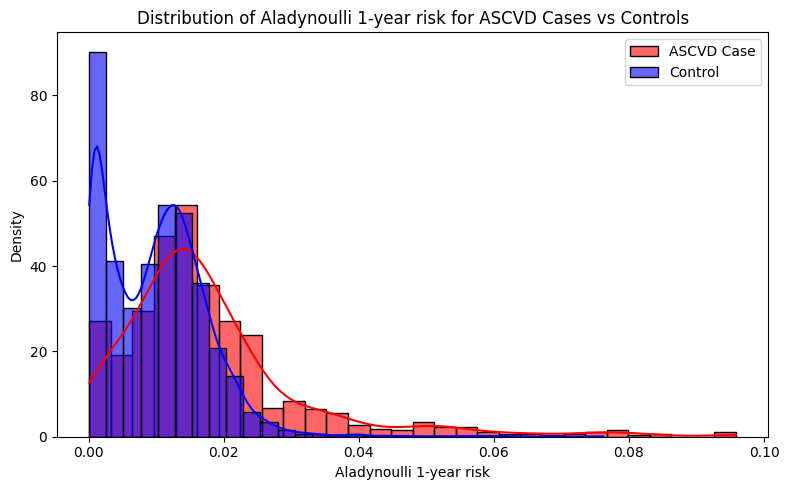

In [70]:

model_path='/Users/sarahurbut/Library/CloudStorage/Dropbox/resultsenrollAWS/results/output_0_10000/model.pt'

model.load_state_dict(torch.load(model_path)['model_state_dict'])

# Get predictions (pi) from the model
with torch.no_grad():
    pi, _, _ = model.forward()  # pi shape: (N, D, T)

test_end

Y_test = Y[test_start:test_end]
FH_test = fh_processed.iloc[test_start:test_end].reset_index(drop=True)
# For each subject, get their enrollment age (from your covariate DataFrame)
# Suppose FH_train is your DataFrame for the training set (reset index to match order)
aladynoulli_1yr_risk_test = []
for i, row in FH_test.iterrows():
    enroll_time = int(row['age'] - 30)
    # Choose the disease indices you want (e.g., ASCVD indices)
    # For a single disease: d_idx = ...
    # For a group: d_indices = [...]
    # Example for ASCVD:
    d_indices = [111, 112, 113, 114, 115, 116]  # adjust as needed
    if enroll_time < 0 or enroll_time >= pi.shape[2]:
        aladynoulli_1yr_risk_train.append(np.nan)
        continue
    # 1-year risk for ASCVD group at enrollment
    pi_diseases = pi[i, d_indices, enroll_time]
    yearly_risk = 1 - torch.prod(1 - pi_diseases)
    aladynoulli_1yr_risk_test.append(yearly_risk.item())

import numpy as np
import torch
ascvd_indices=[111,112,113,114,115,116]
cases = []
controls = []
for i in range(len(FH_test)):
    age = FH_test.iloc[i]['age']
    t_enroll = int(age - 30)
    if t_enroll < 0 or t_enroll >= Y_test.shape[2]:
        continue
    end_time = min(t_enroll + 10, Y_test.shape[2])
    had_event = 0
    for d_idx in ascvd_indices:
        if torch.any(Y_test[i, d_idx, t_enroll:end_time] > 0):
            had_event = 1
            break
    if had_event:
        cases.append(aladynoulli_1yr_risk_test[i])
    else:
        controls.append(aladynoulli_1yr_risk_test[i])
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(cases, color='red', label='ASCVD Case', kde=True, stat='density', bins=30, alpha=0.6)
sns.histplot(controls, color='blue', label='Control', kde=True, stat='density', bins=30, alpha=0.6)
plt.xlabel('Aladynoulli 1-year risk')
plt.ylabel('Density')
plt.title('Distribution of Aladynoulli 1-year risk for ASCVD Cases vs Controls')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
import pandas as pd

# Create DataFrame from both results
df_compare = []
for disease in aladynoulli_results_boot.keys():
    aladyn = dynamic_bootstrap_results[disease]
    cox = cox_results_auc.get(disease, {})
    
    row = {
        'Disease': disease,
        'Aladynoulli_AUC': f"{aladyn['auc']:.3f} ({aladyn['ci_lower']:.3f}-{aladyn['ci_upper']:.3f})",
        'Cox_AUC': f"{cox.get('auc', np.nan):.3f} ({cox.get('ci', (np.nan, np.nan))[0]:.3f}-{cox.get('ci', (np.nan, np.nan))[1]:.3f})" if cox.get('auc') is not None else "N/A",
        'Events': aladyn['n_events'],
        'Rate': f"{aladyn['event_rate']:.1f}%"
    }
    df_compare.append(row)

df_compare = pd.DataFrame(df_compare)

# Sort by number of events descending
df_compare = df_compare.sort_values('Events', ascending=False)

# Save to CSV for R
df_compare.to_csv('model_comparison_results_dynamic.csv', index=False)

# Display nicely formatted table in Python
print("\nModel Comparison Results:")
print("-" * 100)
print(df_compare.to_string(index=False))


Model Comparison Results:
----------------------------------------------------------------------------------------------------
             Disease     Aladynoulli_AUC             Cox_AUC  Events Rate
               ASCVD 0.875 (0.864-0.887) 0.684 (0.662-0.706)     831 8.3%
              Asthma 0.691 (0.672-0.704) 0.499 (0.470-0.518)     606 6.3%
            Diabetes 0.741 (0.726-0.764) 0.645 (0.620-0.665)     581 5.8%
              Anemia 0.719 (0.699-0.736) 0.568 (0.524-0.599)     523 5.2%
         All_Cancers 0.765 (0.741-0.787) 0.713 (0.685-0.737)     480 4.8%
   Thyroid_Disorders 0.709 (0.685-0.729) 0.634 (0.613-0.653)     479 4.8%
          Depression 0.673 (0.639-0.703) 0.474 (0.450-0.502)     405 4.1%
                COPD 0.760 (0.734-0.780) 0.652 (0.624-0.684)     394 3.9%
          Atrial_Fib 0.775 (0.757-0.798) 0.712 (0.687-0.735)     376 3.8%
           Pneumonia 0.784 (0.761-0.807) 0.687 (0.667-0.711)     335 3.4%
    Secondary_Cancer 0.715 (0.665-0.749) 0.630 (0.584-0.67

In [20]:
import pandas as pd

# Create DataFrame from both results
df_compare = []
for disease in aladynoulli_results_boot.keys():
    aladyn = dynamic_bootstrap_results[disease]
    cox = cox_results_auc.get(disease, {})
    
    row = {
        'Disease': disease,
        'Aladynoulli_AUC': f"{aladyn['auc']:.3f} ({aladyn['ci_lower']:.3f}-{aladyn['ci_upper']:.3f})",
        'Cox_AUC': f"{cox.get('auc', np.nan):.3f} ({cox.get('ci', (np.nan, np.nan))[0]:.3f}-{cox.get('ci', (np.nan, np.nan))[1]:.3f})" if cox.get('auc') is not None else "N/A",
        'Events': aladyn['n_events'],
        'Rate': f"{aladyn['event_rate']:.1f}%"
    }
    df_compare.append(row)

df_compare = pd.DataFrame(df_compare)

# Sort by number of events descending
df_compare = df_compare.sort_values('Events', ascending=False)

# Save to CSV for R
df_compare.to_csv('model_comparison_results_dynamic.csv', index=False)

# Display nicely formatted table in Python
print("\nModel Comparison Results:")
print("-" * 100)
print(df_compare.to_string(index=False))


Model Comparison Results:
----------------------------------------------------------------------------------------------------
             Disease     Aladynoulli_AUC             Cox_AUC  Events Rate
               ASCVD 0.875 (0.864-0.887) 0.684 (0.662-0.706)     831 8.3%
              Asthma 0.691 (0.672-0.704) 0.499 (0.470-0.518)     606 6.3%
            Diabetes 0.741 (0.726-0.764) 0.645 (0.620-0.665)     581 5.8%
              Anemia 0.719 (0.699-0.736) 0.568 (0.524-0.599)     523 5.2%
         All_Cancers 0.765 (0.741-0.787) 0.713 (0.685-0.737)     480 4.8%
   Thyroid_Disorders 0.709 (0.685-0.729) 0.634 (0.613-0.653)     479 4.8%
          Depression 0.673 (0.639-0.703) 0.474 (0.450-0.502)     405 4.1%
                COPD 0.760 (0.734-0.780) 0.652 (0.624-0.684)     394 3.9%
          Atrial_Fib 0.775 (0.757-0.798) 0.712 (0.687-0.735)     376 3.8%
           Pneumonia 0.784 (0.761-0.807) 0.687 (0.667-0.711)     335 3.4%
    Secondary_Cancer 0.715 (0.665-0.749) 0.630 (0.584-0.67

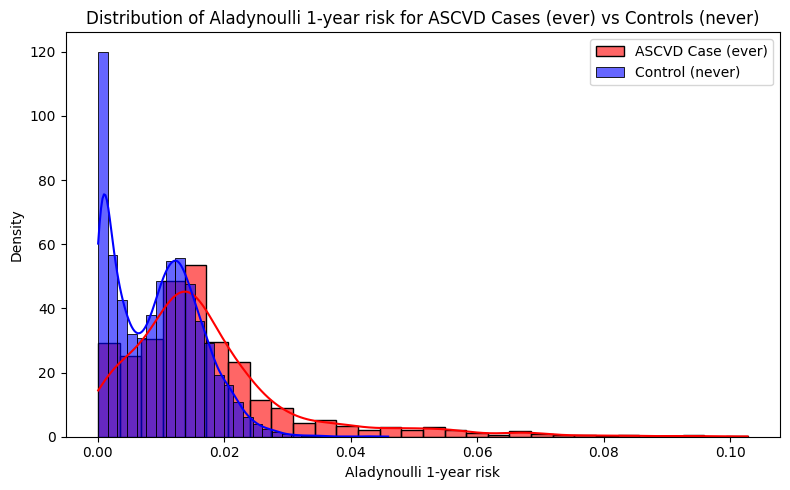

In [48]:
ascvd_indices = [111, 112, 113, 114, 115, 116]  # or whatever indices match your disease_names

cases = []
controls = []
for i in range(len(FH_test)):
    # Check if this person ever had an ASCVD event at any time
    had_event = False
    for d_idx in ascvd_indices:
        if torch.any(Y_test[i, d_idx, :] > 0):
            had_event = True
            break
    if had_event:
        cases.append(aladynoulli_1yr_risk_test[i])
    else:
        controls.append(aladynoulli_1yr_risk_test[i])


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(cases, color='red', label='ASCVD Case (ever)', kde=True, stat='density', bins=30, alpha=0.6)
sns.histplot(controls, color='blue', label='Control (never)', kde=True, stat='density', bins=30, alpha=0.6)
plt.xlabel('Aladynoulli 1-year risk')
plt.ylabel('Density')
plt.title('Distribution of Aladynoulli 1-year risk for ASCVD Cases (ever) vs Controls (never)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:

aladynoulli_1yr_risk_test = np.array(aladynoulli_1yr_risk_test)
aladynoulli_1yr_risk_test.shape

from fig5utils import *
test_start = 0
test_end = 10000

   # If you have Aladynoulli 1-year risk for the test set, use:
aladynoulli_1yr_risk_test = aladynoulli_1yr_risk_test  # Should be length 10,000, one per patient in this batch

results = evaluate_cox_baseline_models_auc_with_aladynoulli(
    fitted_models,
    Y_test,
    FH_test,
    disease_mapping,
    major_diseases,
    disease_names,
    aladynoulli_1yr_risk_test,
    follow_up_duration_years=10,
    n_bootstraps=100
)


In [25]:
coxmodel = fitted_models['ASCVD']  # Replace 'DiseaseName' with the actual key
print(coxmodel.summary)                  # Detailed table: coef, exp(coef), p, etc.
print(coxmodel.params_)    

                      coef     exp(coef)  se(coef)  coef lower 95%  \
covariate                                                            
sex               0.956755  2.603235e+00  0.084071        0.791979   
aladynoulli_1yr  21.915585  3.294712e+09  3.194608       15.654268   
fh                0.284061  1.328514e+00  0.086572        0.114384   

                 coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                   
sex                    1.121531         2.207761e+00         3.069551e+00   
aladynoulli_1yr       28.176901         6.288722e+06         1.726127e+12   
fh                     0.453739         1.121183e+00         1.574187e+00   

                 cmp to          z             p   -log2(p)  
covariate                                                    
sex                 0.0  11.380307  5.241504e-30  97.267862  
aladynoulli_1yr     0.0   6.860180  6.877386e-12  37.081277  
fh             

In [ ]:
for disease, res in glm_results.items():
    print(f"{disease}: AUC={res['auc']:.3f} (Events: {res['n_events']})")

ASCVD: AUC=0.702 (Events: 535)
Diabetes: AUC=0.655 (Events: 586)
Atrial_Fib: AUC=0.708 (Events: 366)
CKD: AUC=0.724 (Events: 120)
All_Cancers: AUC=0.740 (Events: 319)
Stroke: AUC=0.631 (Events: 50)
Heart_Failure: AUC=0.711 (Events: 74)
Pneumonia: AUC=0.651 (Events: 358)
COPD: AUC=0.668 (Events: 281)
Osteoporosis: AUC=0.753 (Events: 210)
Anemia: AUC=0.573 (Events: 281)
Colorectal_Cancer: AUC=0.649 (Events: 81)
Breast_Cancer: AUC=0.481 (Events: 37)
Prostate_Cancer: AUC=0.685 (Events: 204)
Lung_Cancer: AUC=0.641 (Events: 83)
Bladder_Cancer: AUC=0.751 (Events: 56)
Secondary_Cancer: AUC=0.590 (Events: 153)
Depression: AUC=0.575 (Events: 393)
Anxiety: AUC=0.563 (Events: 260)
Bipolar_Disorder: AUC=0.489 (Events: 23)
Rheumatoid_Arthritis: AUC=0.654 (Events: 109)
Psoriasis: AUC=0.574 (Events: 57)
Ulcerative_Colitis: AUC=0.437 (Events: 37)
Crohns_Disease: AUC=0.554 (Events: 30)
Asthma: AUC=0.525 (Events: 589)
Parkinsons: AUC=0.728 (Events: 47)
Multiple_Sclerosis: AUC=0.650 (Events: 19)
Thyroid_D

In [26]:
coxmodel = fitted_models['Prostate_Cancer']  # Replace 'DiseaseName' with the actual key
print(coxmodel.summary)                  # Detailed table: coef, exp(coef), p, etc.
print(coxmodel.params_)    

                      coef     exp(coef)   se(coef)  coef lower 95%  \
covariate                                                             
aladynoulli_1yr -25.929887  5.480160e-12  10.767318      -47.033443   
fh                0.429203  1.536033e+00   0.253519       -0.067685   

                 coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                   
aladynoulli_1yr       -4.826331         3.746581e-21             0.008016   
fh                     0.926091         9.345551e-01             2.524622   

                 cmp to         z         p  -log2(p)  
covariate                                              
aladynoulli_1yr     0.0 -2.408203  0.016031  5.962967  
fh                  0.0  1.692983  0.090459  3.466597  
covariate
aladynoulli_1yr   -25.929887
fh                  0.429203
Name: coef, dtype: float64


In [22]:
import pandas as pd

# Create DataFrame from both results
df_compare = []
for disease in aladynoulli_results_boot.keys():
    aladyn = results[disease]
    cox = cox_results_auc.get(disease, {})
    
    row = {
        'Disease': disease,
       'Cox_Aladyn_AUC': f"{aladyn.get('auc', np.nan):.3f} ({aladyn.get('ci', (np.nan, np.nan))[0]:.3f}-{aladyn.get('ci', (np.nan, np.nan))[1]:.3f})" if aladyn.get('auc') is not None else "N/A",
        'Cox_AUC': f"{cox.get('auc', np.nan):.3f} ({cox.get('ci', (np.nan, np.nan))[0]:.3f}-{cox.get('ci', (np.nan, np.nan))[1]:.3f})" if cox.get('auc') is not None else "N/A",
        'Events': aladyn['n_events']
        #'Rate': f"{aladyn['event_rate']:.1f}%"
    }
    df_compare.append(row)

df_compare = pd.DataFrame(df_compare)

# Sort by number of events descending
df_compare = df_compare.sort_values('Events', ascending=False)

# Save to CSV for R
df_compare.to_csv('model_comparison_results_dynamic.csv', index=False)

# Display nicely formatted table in Python
print("\nModel Comparison Results:")
print("-" * 100)
print(df_compare.to_string(index=False))


Model Comparison Results:
----------------------------------------------------------------------------------------------------
             Disease      Cox_Aladyn_AUC             Cox_AUC  Events
              Asthma 0.527 (0.506-0.549) 0.499 (0.470-0.518)     606
            Diabetes 0.605 (0.586-0.629) 0.645 (0.620-0.665)     581
               ASCVD 0.686 (0.662-0.706) 0.684 (0.662-0.706)     530
   Thyroid_Disorders 0.644 (0.621-0.667) 0.634 (0.613-0.653)     424
          Depression 0.551 (0.522-0.584) 0.474 (0.450-0.502)     405
          Atrial_Fib 0.601 (0.577-0.631) 0.712 (0.687-0.735)     376
           Pneumonia 0.577 (0.548-0.612) 0.687 (0.667-0.711)     335
         All_Cancers 0.637 (0.607-0.666) 0.713 (0.685-0.737)     319
                COPD 0.535 (0.508-0.569) 0.652 (0.624-0.684)     272
              Anemia 0.527 (0.491-0.560) 0.568 (0.524-0.599)     272
             Anxiety 0.549 (0.517-0.580) 0.510 (0.484-0.553)     241
        Osteoporosis 0.652 (0.624-0.685) 0.7

In [27]:
model_path='/Users/sarahurbut/Library/CloudStorage/Dropbox/resultsenrollAWS/results/output_0_10000/model.pt'
model.load_state_dict(torch.load(model_path)['model_state_dict'])

# Get predictions (pi) from the model
with torch.no_grad():
    pi, _, _ = model.forward()  # pi shape: (N, D, T)

# For each subject, get their enrollment age (from your covariate DataFrame)
# Suppose FH_train is your DataFrame for the training set (reset index to match order)
aladynoulli_1yr_risk_test = []
for i, row in FH_train.iterrows():
    enroll_time = int(row['age'] - 30)
    # Choose the disease indices you want (e.g., ASCVD indices)
    # For a single disease: d_idx = ...
    # For a group: d_indices = [...]
    # Example for ASCVD:
    d_indices = [111, 112, 113, 114, 115, 116]  # adjust as needed
    if enroll_time < 0 or enroll_time >= pi.shape[2]:
        aladynoulli_1yr_risk_train.append(np.nan)
        continue
    # 1-year risk for ASCVD group at enrollment
    pi_diseases = pi[i, d_indices, enroll_time]
    yearly_risk = 1 - torch.prod(1 - pi_diseases)
    aladynoulli_1yr_risk_test.append(yearly_risk.item())

aladynoulli_1yr_risk_test = np.array(aladynoulli_1yr_risk_test)
aladynoulli_1yr_risk_test.shape

from fig5utils import *
test_start = 0
test_end = 10000

Y_test = Y[test_start:test_end]
FH_test = fh_processed.iloc[test_start:test_end].reset_index(drop=True)
   # If you have Aladynoulli 1-year risk for the test set, use:
aladynoulli_1yr_risk_test = aladynoulli_1yr_risk_test  # Should be length 10,000, one per patient in this batch


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_89680/4174347894.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)[

In [28]:
torch.manual_seed(0)
np.random.seed(0)
# Initialize with psi and clusters
model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters

train_indices=np.arange(20000, 30000)
FH_train = fh_processed.iloc[train_indices].reset_index(drop=True)
FH_train.shape
FH_train.tail()
# Load the model
model_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/resultsenrollAWS/results/output_20000_30000/model.pt'
model.load_state_dict(torch.load(model_path)['model_state_dict'])

# Get predictions (pi) from the model
with torch.no_grad():
    pi, _, _ = model.forward()  # pi shape: (N, D, T)

# For each subject, get their enrollment age (from your covariate DataFrame)
# Suppose FH_train is your DataFrame for the training set (reset index to match order)
aladynoulli_1yr_risk_train = []
for i, row in FH_train.iterrows():
    enroll_time = int(row['age'] - 30)
    # Choose the disease indices you want (e.g., ASCVD indices)
    # For a single disease: d_idx = ...
    # For a group: d_indices = [...]
    # Example for ASCVD:
    d_indices = [111, 112, 113, 114, 115, 116]  # adjust as needed
    if enroll_time < 0 or enroll_time >= pi.shape[2]:
        aladynoulli_1yr_risk_train.append(np.nan)
        continue
    # 1-year risk for ASCVD group at enrollment
    pi_diseases = pi[i, d_indices, enroll_time]
    yearly_risk = 1 - torch.prod(1 - pi_diseases)
    aladynoulli_1yr_risk_train.append(yearly_risk.item())

aladynoulli_1yr_risk_train = np.array(aladynoulli_1yr_risk_train)



Calculating gamma for k=0:
Number of diseases in cluster: 16.0
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -11.9623, -13.8155])
Base value centered (first 5): tensor([-0.1879, -0.1879, -0.1879,  1.6653, -0.1879])
Base value centered mean: -3.345489574257954e-07
Gamma init for k=0 (first 5): tensor([ 0.0072,  0.0061, -0.0051,  0.0064,  0.0244])

Calculating gamma for k=1:
Number of diseases in cluster: 21.0
Base value (first 5): tensor([-13.3449, -13.8155, -13.3449, -13.3449, -12.4036])
Base value centered (first 5): tensor([ 0.1505, -0.3201,  0.1505,  0.1505,  1.0918])
Base value centered mean: -1.8495559288567165e-06
Gamma init for k=1 (first 5): tensor([0.0041, 0.0016, 0.0004, 0.0024, 0.0014])

Calculating gamma for k=2:
Number of diseases in cluster: 15.0
Base value (first 5): tensor([-13.8155, -13.8155, -13.1566, -11.8388, -12.4977])
Base value centered (first 5): tensor([-0.3849, -0.3849,  0.2740,  1.5918,  0.9329])
Base value centered mean: 9.290695288655115e-07


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_89680/2430726624.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

In [35]:
from fig5utils import *
from fig5utils import *
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message="DataFrame Index is not unique")
train_indices = np.arange(0, 10000)
test_indices = np.arange(20000, 30000)

glm_results_with_noulli = fit_and_eval_glm_baseline_models_with_noulli(
    Y_full=Y,
    FH_processed=fh_processed,
    train_indices=train_indices,
    test_indices=test_indices,
    disease_mapping=disease_mapping,
    major_diseases=major_diseases,
    disease_names=model.disease_names,
    aladynoulli_1yr_risk_test=aladynoulli_1yr_risk_test,
    aladynoulli_1yr_risk_train=aladynoulli_1yr_risk_train,
    follow_up_duration_years=10
)

- Fitting GLM+Noulli for ASCVD...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for ASCVD: 0.702 (Events: 535/10000)
- Fitting GLM+Noulli for Diabetes...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for Diabetes: 0.649 (Events: 586/10000)
- Fitting GLM+Noulli for Atrial_Fib...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for Atrial_Fib: 0.707 (Events: 366/10000)
- Fitting GLM+Noulli for CKD...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for CKD: 0.724 (Events: 120/10000)
- Fitting GLM+Noulli for All_Cancers...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for All_Cancers: 0.741 (Events: 319/10000)
- Fitting GLM+Noulli for Stroke...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for Stroke: 0.637 (Events: 50/10000)
- Fitting GLM+Noulli for Heart_Failure...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for Heart_Failure: 0.711 (Events: 74/10000)
- Fitting GLM+Noulli for Pneumonia...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for Pneumonia: 0.651 (Events: 358/10000)
- Fitting GLM+Noulli for COPD...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for COPD: 0.669 (Events: 281/10000)
- Fitting GLM+Noulli for Osteoporosis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for Osteoporosis: 0.752 (Events: 210/10000)
- Fitting GLM+Noulli for Anemia...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for Anemia: 0.568 (Events: 281/10000)
- Fitting GLM+Noulli for Colorectal_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for Colorectal_Cancer: 0.616 (Events: 81/10000)
- Fitting GLM+Noulli for Breast_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for Breast_Cancer: 0.482 (Events: 37/5395)
- Fitting GLM+Noulli for Prostate_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for Prostate_Cancer: 0.685 (Events: 204/4605)
- Fitting GLM+Noulli for Lung_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for Lung_Cancer: 0.643 (Events: 83/10000)
- Fitting GLM+Noulli for Bladder_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for Bladder_Cancer: 0.751 (Events: 56/10000)
- Fitting GLM+Noulli for Secondary_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for Secondary_Cancer: 0.592 (Events: 153/10000)
- Fitting GLM+Noulli for Depression...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for Depression: 0.573 (Events: 393/10000)
- Fitting GLM+Noulli for Anxiety...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for Anxiety: 0.547 (Events: 260/10000)
- Fitting GLM+Noulli for Bipolar_Disorder...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for Bipolar_Disorder: 0.486 (Events: 23/10000)
- Fitting GLM+Noulli for Rheumatoid_Arthritis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for Rheumatoid_Arthritis: 0.638 (Events: 109/10000)
- Fitting GLM+Noulli for Psoriasis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for Psoriasis: 0.491 (Events: 57/10000)
- Fitting GLM+Noulli for Ulcerative_Colitis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for Ulcerative_Colitis: 0.437 (Events: 37/10000)
- Fitting GLM+Noulli for Crohns_Disease...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for Crohns_Disease: 0.513 (Events: 30/10000)
- Fitting GLM+Noulli for Asthma...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for Asthma: 0.530 (Events: 589/10000)
- Fitting GLM+Noulli for Parkinsons...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for Parkinsons: 0.726 (Events: 47/10000)
- Fitting GLM+Noulli for Multiple_Sclerosis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM+Noulli AUC for Multiple_Sclerosis: 0.603 (Events: 19/10000)
- Fitting GLM+Noulli for Thyroid_Disorders...
  GLM+Noulli AUC for Thyroid_Disorders: 0.650 (Events: 381/10000)


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

In [36]:
for disease, res in glm_results_with_noulli.items():
    print(f"{disease}: AUC={res['auc']:.3f} (Events: {res['n_events']})")

ASCVD: AUC=0.702 (Events: 535)
Diabetes: AUC=0.649 (Events: 586)
Atrial_Fib: AUC=0.707 (Events: 366)
CKD: AUC=0.724 (Events: 120)
All_Cancers: AUC=0.741 (Events: 319)
Stroke: AUC=0.637 (Events: 50)
Heart_Failure: AUC=0.711 (Events: 74)
Pneumonia: AUC=0.651 (Events: 358)
COPD: AUC=0.669 (Events: 281)
Osteoporosis: AUC=0.752 (Events: 210)
Anemia: AUC=0.568 (Events: 281)
Colorectal_Cancer: AUC=0.616 (Events: 81)
Breast_Cancer: AUC=0.482 (Events: 37)
Prostate_Cancer: AUC=0.685 (Events: 204)
Lung_Cancer: AUC=0.643 (Events: 83)
Bladder_Cancer: AUC=0.751 (Events: 56)
Secondary_Cancer: AUC=0.592 (Events: 153)
Depression: AUC=0.573 (Events: 393)
Anxiety: AUC=0.547 (Events: 260)
Bipolar_Disorder: AUC=0.486 (Events: 23)
Rheumatoid_Arthritis: AUC=0.638 (Events: 109)
Psoriasis: AUC=0.491 (Events: 57)
Ulcerative_Colitis: AUC=0.437 (Events: 37)
Crohns_Disease: AUC=0.513 (Events: 30)
Asthma: AUC=0.530 (Events: 589)
Parkinsons: AUC=0.726 (Events: 47)
Multiple_Sclerosis: AUC=0.603 (Events: 19)
Thyroid_D

In [ ]:
for disease, res in glm_results.items():
    print(f"{disease}: AUC={res['auc']:.3f} (Events: {res['n_events']})")

ASCVD: AUC=0.702 (Events: 535)
Diabetes: AUC=0.655 (Events: 586)
Atrial_Fib: AUC=0.708 (Events: 366)
CKD: AUC=0.724 (Events: 120)
All_Cancers: AUC=0.740 (Events: 319)
Stroke: AUC=0.631 (Events: 50)
Heart_Failure: AUC=0.711 (Events: 74)
Pneumonia: AUC=0.651 (Events: 358)
COPD: AUC=0.668 (Events: 281)
Osteoporosis: AUC=0.753 (Events: 210)
Anemia: AUC=0.573 (Events: 281)
Colorectal_Cancer: AUC=0.649 (Events: 81)
Breast_Cancer: AUC=0.481 (Events: 37)
Prostate_Cancer: AUC=0.685 (Events: 204)
Lung_Cancer: AUC=0.641 (Events: 83)
Bladder_Cancer: AUC=0.751 (Events: 56)
Secondary_Cancer: AUC=0.590 (Events: 153)
Depression: AUC=0.575 (Events: 393)
Anxiety: AUC=0.563 (Events: 260)
Bipolar_Disorder: AUC=0.489 (Events: 23)
Rheumatoid_Arthritis: AUC=0.654 (Events: 109)
Psoriasis: AUC=0.574 (Events: 57)
Ulcerative_Colitis: AUC=0.437 (Events: 37)
Crohns_Disease: AUC=0.554 (Events: 30)
Asthma: AUC=0.525 (Events: 589)
Parkinsons: AUC=0.728 (Events: 47)
Multiple_Sclerosis: AUC=0.650 (Events: 19)
Thyroid_D

In [34]:
from fig5utils import *
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message="DataFrame Index is not unique")
train_indices = np.arange(0, 10000)
test_indices = np.arange(20000, 30000)

glm_results_no_noulli= fit_and_eval_glm_baseline_models(
    Y_full=Y,
    FH_processed=fh_processed,
    train_indices=train_indices,
    test_indices=test_indices,
    disease_mapping=disease_mapping,
    major_diseases=major_diseases,
    disease_names=model.disease_names,
    follow_up_duration_years=10
)


for disease, res in glm_results_no_noulli.items():
    print(f"{disease}: AUC={res['auc']:.3f} (Events: {res['n_events']})")

- Fitting GLM for ASCVD...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for ASCVD: 0.702 (Events: 535/10000)
- Fitting GLM for Diabetes...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for Diabetes: 0.649 (Events: 586/10000)
- Fitting GLM for Atrial_Fib...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for Atrial_Fib: 0.706 (Events: 366/10000)
- Fitting GLM for CKD...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for CKD: 0.724 (Events: 120/10000)
- Fitting GLM for All_Cancers...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for All_Cancers: 0.741 (Events: 319/10000)
- Fitting GLM for Stroke...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for Stroke: 0.638 (Events: 50/10000)
- Fitting GLM for Heart_Failure...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for Heart_Failure: 0.711 (Events: 74/10000)
- Fitting GLM for Pneumonia...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for Pneumonia: 0.651 (Events: 358/10000)
- Fitting GLM for COPD...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for COPD: 0.669 (Events: 281/10000)
- Fitting GLM for Osteoporosis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for Osteoporosis: 0.752 (Events: 210/10000)
- Fitting GLM for Anemia...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for Anemia: 0.568 (Events: 281/10000)
- Fitting GLM for Colorectal_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for Colorectal_Cancer: 0.615 (Events: 81/10000)
- Fitting GLM for Breast_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for Breast_Cancer: 0.483 (Events: 37/5395)
- Fitting GLM for Prostate_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for Prostate_Cancer: 0.685 (Events: 204/4605)
- Fitting GLM for Lung_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for Lung_Cancer: 0.642 (Events: 83/10000)
- Fitting GLM for Bladder_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for Bladder_Cancer: 0.752 (Events: 56/10000)
- Fitting GLM for Secondary_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for Secondary_Cancer: 0.592 (Events: 153/10000)
- Fitting GLM for Depression...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for Depression: 0.574 (Events: 393/10000)
- Fitting GLM for Anxiety...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for Anxiety: 0.547 (Events: 260/10000)
- Fitting GLM for Bipolar_Disorder...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for Bipolar_Disorder: 0.489 (Events: 23/10000)
- Fitting GLM for Rheumatoid_Arthritis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for Rheumatoid_Arthritis: 0.640 (Events: 109/10000)
- Fitting GLM for Psoriasis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for Psoriasis: 0.491 (Events: 57/10000)
- Fitting GLM for Ulcerative_Colitis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for Ulcerative_Colitis: 0.436 (Events: 37/10000)
- Fitting GLM for Crohns_Disease...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for Crohns_Disease: 0.510 (Events: 30/10000)
- Fitting GLM for Asthma...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for Asthma: 0.530 (Events: 589/10000)
- Fitting GLM for Parkinsons...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for Parkinsons: 0.726 (Events: 47/10000)
- Fitting GLM for Multiple_Sclerosis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20

  GLM AUC for Multiple_Sclerosis: 0.601 (Events: 19/10000)
- Fitting GLM for Thyroid_Disorders...
  GLM AUC for Thyroid_Disorders: 0.650 (Events: 381/10000)
ASCVD: AUC=0.702 (Events: 535)
Diabetes: AUC=0.649 (Events: 586)
Atrial_Fib: AUC=0.706 (Events: 366)
CKD: AUC=0.724 (Events: 120)
All_Cancers: AUC=0.741 (Events: 319)
Stroke: AUC=0.638 (Events: 50)
Heart_Failure: AUC=0.711 (Events: 74)
Pneumonia: AUC=0.651 (Events: 358)
COPD: AUC=0.669 (Events: 281)
Osteoporosis: AUC=0.752 (Events: 210)
Anemia: AUC=0.568 (Events: 281)
Colorectal_Cancer: AUC=0.615 (Events: 81)
Breast_Cancer: AUC=0.483 (Events: 37)
Prostate_Cancer: AUC=0.685 (Events: 204)
Lung_Cancer: AUC=0.642 (Events: 83)
Bladder_Cancer: AUC=0.752 (Events: 56)
Secondary_Cancer: AUC=0.592 (Events: 153)
Depression: AUC=0.574 (Events: 393)
Anxiety: AUC=0.547 (Events: 260)
Bipolar_Disorder: AUC=0.489 (Events: 23)
Rheumatoid_Arthritis: AUC=0.640 (Events: 109)
Psoriasis: AUC=0.491 (Events: 57)
Ulcerative_Colitis: AUC=0.436 (Events: 37)
C

/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:20